### Qatar Airlines Customer Satisfaction Reviews

Customer satisfaction should be a top priority for all successful businesses, and the aviation industry is no exception. 

This project aims to analyze data collected from airline reviews to build a predictive model that forecasts whether a passenger will recommend the airline and choose to fly with it again. A satisfied passenger is far more likely to become a repeat customer, which underscores the importance of understanding and improving their experience.

By accurately predicting which passengers are likely to be dissatisfied, the underlying causes of their dissatisfaction can be identified. This enables the airline to make targeted improvements, ultimately enhancing overall customer satisfaction and loyalty.

This is a comprehensive data science end to end project that encompasses the entire process from start to finish. It begins with web scraping passenger reviews from [skytrax]('https://www.airlinequality.com/review-pages/a-z-airline-reviews/'), followed by cleaning and exploring the dataset. The next steps involve analyzing and visualizing the data to uncover key insights, and finally, building predictive models to forecast future trends and outcomes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [167]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# For metrics and helpful functions
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,GridSearchCV,RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve


In [3]:
qa_df=pd.read_csv('Qatar_Airways.csv')

In [9]:
qa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           1723 non-null   object 
 1   aircraft         1337 non-null   object 
 2   travel_type      2033 non-null   object 
 3   travel_class     2460 non-null   object 
 4   route            2030 non-null   object 
 5   date             2024 non-null   object 
 6   seating_comfort  2417 non-null   float64
 7   staff_service    2415 non-null   float64
 8   food_quality     2382 non-null   float64
 9   entertainment    2251 non-null   float64
 10  wifi             1044 non-null   float64
 11  ground_service   2005 non-null   float64
 12  value_for_money  2460 non-null   int64  
 13  recommended      2460 non-null   object 
 14  overall_rating   2459 non-null   float64
 15  review           2460 non-null   object 
dtypes: float64(7), int64(1), object(8)
memory usage: 307.6+ KB


In [10]:
# change date column datatype to datetime
qa_df['date']=pd.to_datetime(qa_df['date'])


In [14]:
# create "year" and "month" columns

qa_df['year']=pd.to_datetime(qa_df['date']).dt.year
qa_df['month']=pd.to_datetime(qa_df['date']).dt.month

In [16]:
#Since most of the records before the year 2016 were null, let's remove them
qa_df=qa_df[qa_df['year'] >=2016]

In [35]:
qa_df.shape

(1815, 18)

In [18]:
#check for missing values
qa_df.isna().sum()

status              93
aircraft           659
travel_type          0
travel_class         0
route                1
date                 0
seating_comfort     43
staff_service       45
food_quality        78
entertainment      196
wifi               853
ground_service      20
value_for_money      0
recommended          0
overall_rating       1
review               0
year                 0
month                0
dtype: int64

In [19]:
qa_df.columns

Index(['status', 'aircraft', 'travel_type', 'travel_class', 'route', 'date',
       'seating_comfort', 'staff_service', 'food_quality', 'entertainment',
       'wifi', 'ground_service', 'value_for_money', 'recommended',
       'overall_rating', 'review', 'year', 'month'],
      dtype='object')

Remove unnecessaary columns as well as the feature 'wifi' as half of its records were missing.

In [44]:
df=qa_df[['travel_type', 'travel_class', 'route', 'date',
       'seating_comfort', 'staff_service', 'food_quality', 'entertainment',
        'ground_service', 'value_for_money', 'recommended',
       'overall_rating', 'review', 'year', 'month']]

In [45]:
# Since the missing information is for those features which were ordered categorical data, missing records were filled with the most frequent value
cols_to_fill=['seating_comfort', 'staff_service', 'food_quality', 'entertainment','ground_service']
# Fill missing values with the mode for each specified column
for column in cols_to_fill:
    mode_value = df[column].mode()[0]  # Calculate the mode of the column
    df[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode

# Check if the missing values have been filled
print(df[cols_to_fill].isnull().sum())

seating_comfort    0
staff_service      0
food_quality       0
entertainment      0
ground_service     0
dtype: int64


In [47]:
df.shape

(1815, 15)

In [48]:
# There are 1 missing record for each of route and overall_rating columns
df.dropna(subset=['route','overall_rating'],inplace = True)


In [49]:
df.isna().sum()

travel_type        0
travel_class       0
route              0
date               0
seating_comfort    0
staff_service      0
food_quality       0
entertainment      0
ground_service     0
value_for_money    0
recommended        0
overall_rating     0
review             0
year               0
month              0
dtype: int64

In [50]:
df.shape

(1813, 15)

In [53]:
df=df.reset_index()

### Exploratory Data Analysis

create "sentiment" column from "review" column and see how many of those reviews were positive,negative or neutral



In [56]:
analyzer=SentimentIntensityAnalyzer()

scores=[]

for i in range(len(df['review'])):
    score=analyzer.polarity_scores(df['review'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i >=0.5:
        sentiment.append('Positive')
    elif i <=(-0.5):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['sentiment']=pd.Series(np.array(sentiment))

In [66]:
tab=df.groupby('sentiment')['review'].count().reset_index().sort_values('sentiment',ascending=False)
tab.style.background_gradient(cmap='Blues')

,sentiment,review
2,Positive,1272
1,Neutral,259
0,Negative,282


### Visualization

Now let's examine variables that we are interested in, and create plots to visualize relationships between variables.

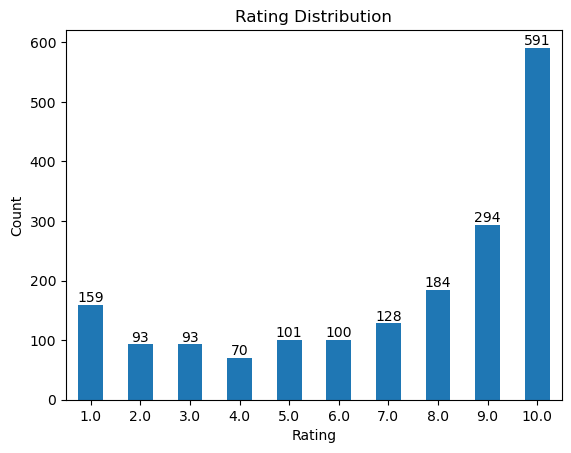

In [83]:
# distribution plot for 'rating' column

rating_counts = df['overall_rating'].value_counts().sort_index()
rating_counts.plot(kind='bar')

plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')

# Show labels on the bars
for index, value in enumerate(rating_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=0)
# Now, display the plot
plt.show()

Create a column called 'Season' from the 'month' column

In [92]:
df['Season'] = df['month_year'].dt.month % 12 // 3 + 1  

# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Season'].map(season_map)

Monthly Reviews Count

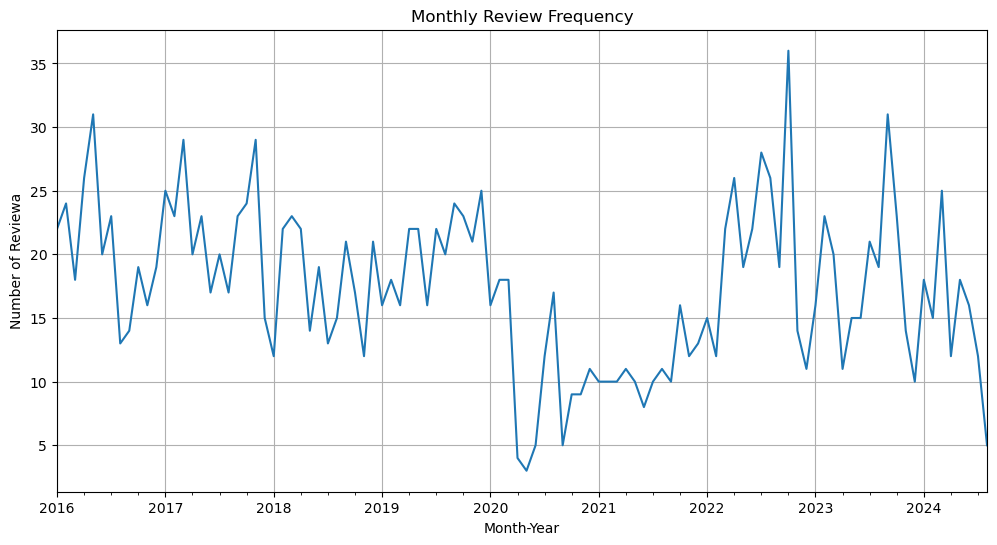

In [79]:
# Group by month_year and count the number of occurrences
monthly_review_frequency = df.groupby('month_year').size()

# Plot the monthly travel frequency
plt.figure(figsize=(12, 6))
monthly_review_frequency.plot()
plt.title('Monthly Review Frequency')
plt.xlabel('Month-Year')
plt.ylabel('Number of Reviewa')
plt.grid(True)
plt.show()


Yearly Passenger Reviews

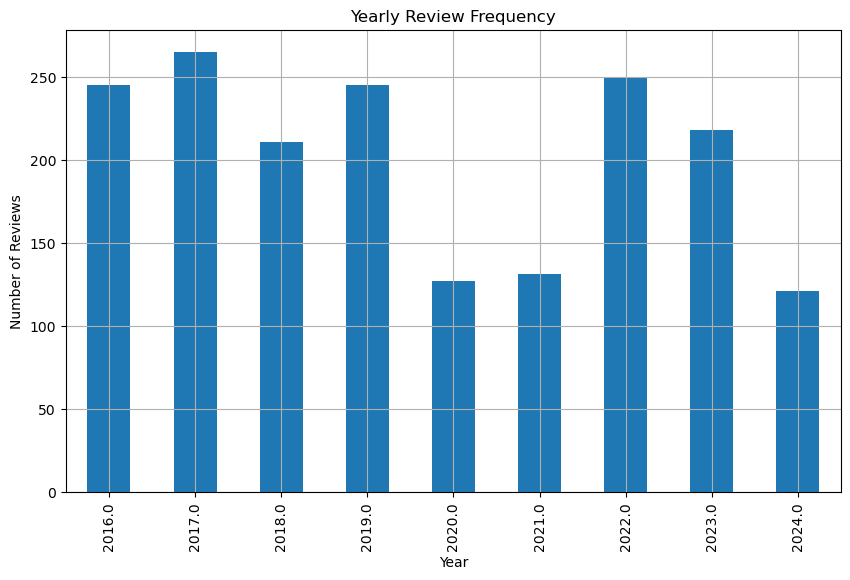

In [80]:
# Group by Year and count the number of occurrences
yearly_review_frequency = df.groupby('year').size()

# Plot the yearly travel frequency
plt.figure(figsize=(10, 6))
yearly_review_frequency.plot(kind='bar')
plt.title('Yearly Review Frequency')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

Monthly Passenger Satisfaction

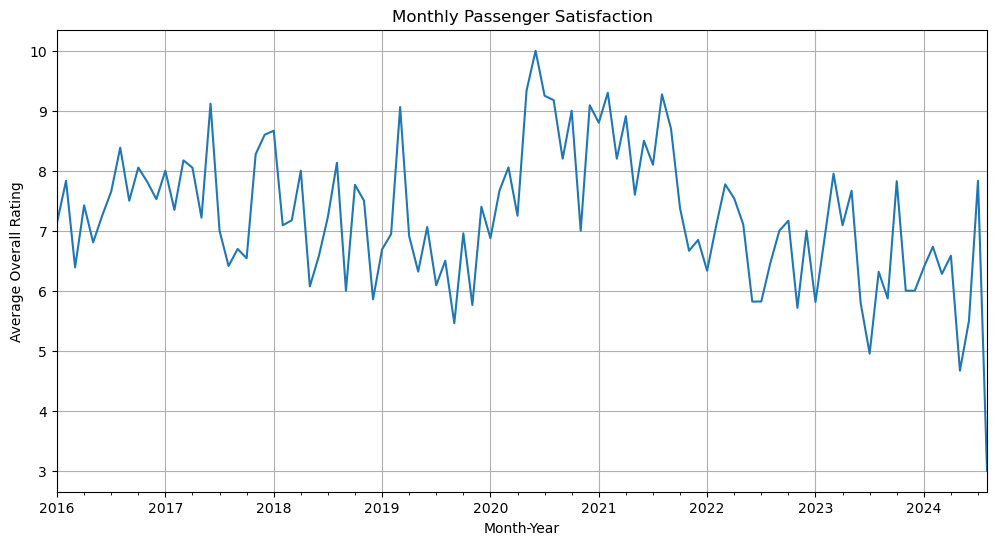

In [75]:
# Calculate the mean overall_rating for each month
monthly_satisfaction = df.groupby('month_year')['overall_rating'].mean()

# Plot the monthly satisfaction trend
plt.figure(figsize=(12, 6))
monthly_satisfaction.plot()
plt.title('Monthly Passenger Satisfaction')
plt.xlabel('Month-Year')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()


Yearly Passenger Satisfaction


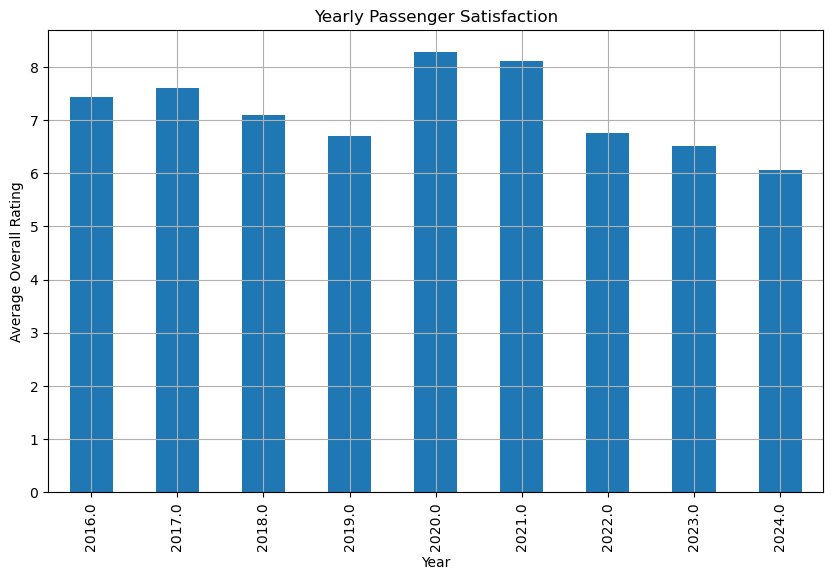

In [77]:
# Calculate the mean overall_rating for each year
yearly_satisfaction = df.groupby('year')['overall_rating'].mean()

# Plot the yearly satisfaction trend
plt.figure(figsize=(10, 6))
yearly_satisfaction.plot(kind='bar')
plt.title('Yearly Passenger Satisfaction')
plt.xlabel('Year')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

Monthly Rating Consistency

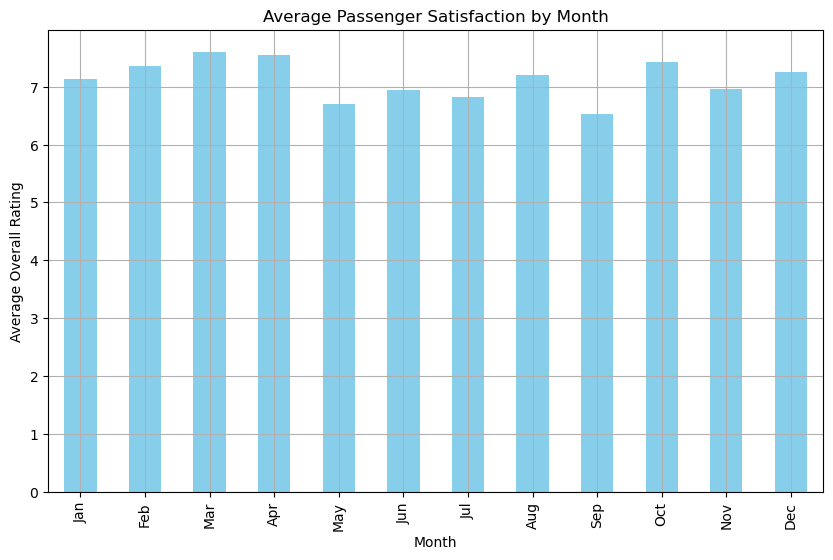

In [85]:
# Calculate the average rating for each month
monthly_avg_rating = df.groupby('month')['overall_rating'].mean()

# Plot the average rating for each month
plt.figure(figsize=(10, 6))
monthly_avg_rating.plot(kind='bar', color='skyblue')
plt.title('Average Passenger Satisfaction by Month')
plt.xlabel('Month')
plt.ylabel('Average Overall Rating')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


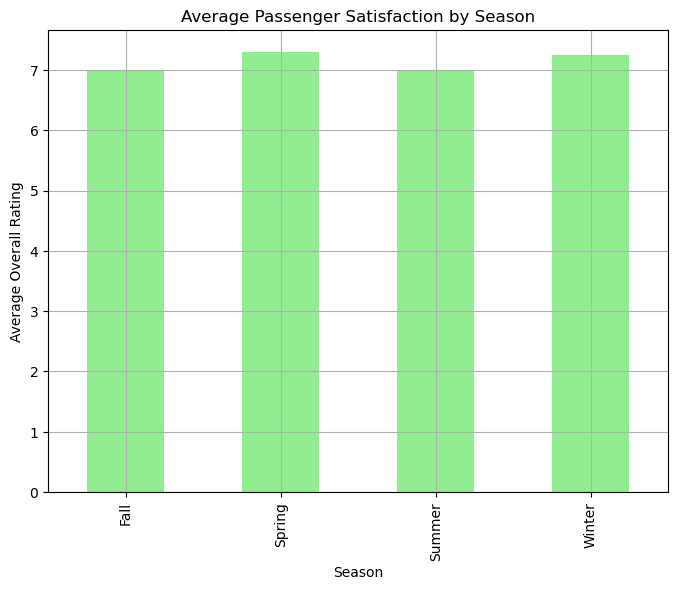

In [93]:
seasonal_avg_rating = df.groupby('Season')['overall_rating'].mean()

# Plot the average rating for each season
plt.figure(figsize=(8, 6))
seasonal_avg_rating.plot(kind='bar', color='lightgreen')
plt.title('Average Passenger Satisfaction by Season')
plt.xlabel('Season')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

#### Advanced Analysis: Hypothesis Testing

Let's further conduct statistical test ANOVA to see if the differences in ratings across months or seasons are statistically significant.

In [88]:
from scipy.stats import f_oneway

# ANOVA test across months
anova_month = f_oneway(*[df[df['month'] == month]['overall_rating'].dropna() for month in range(1, 13)])
print(f'ANOVA Test across Months: F-statistic={anova_month.statistic}, p-value={anova_month.pvalue}')

ANOVA Test across Months: F-statistic=1.8983286006663043, p-value=0.03535793568786398


p-value = 0.035: Since the p-value  is less than 0.05, it is possible to reject the null hypothesis. This means that there is statistically significant evidence to suggest that the average passenger satisfaction ratings are not equal across all months. In other words, the differences in ratings between some months are statistically significant and not due to random chance.

This could suggest that certain months have consistently higher or lower satisfaction, which could be due to various factors like peak travel periods, seasonal weather effects, or changes in service quality.

##### Impact of Travel Class on Satisfaction

In [100]:
df.groupby(['travel_class'])['overall_rating'].mean()

travel_class
Business Class      7.538117
Economy Class       6.841915
First Class         8.200000
Premium Economy    10.000000
Name: overall_rating, dtype: float64

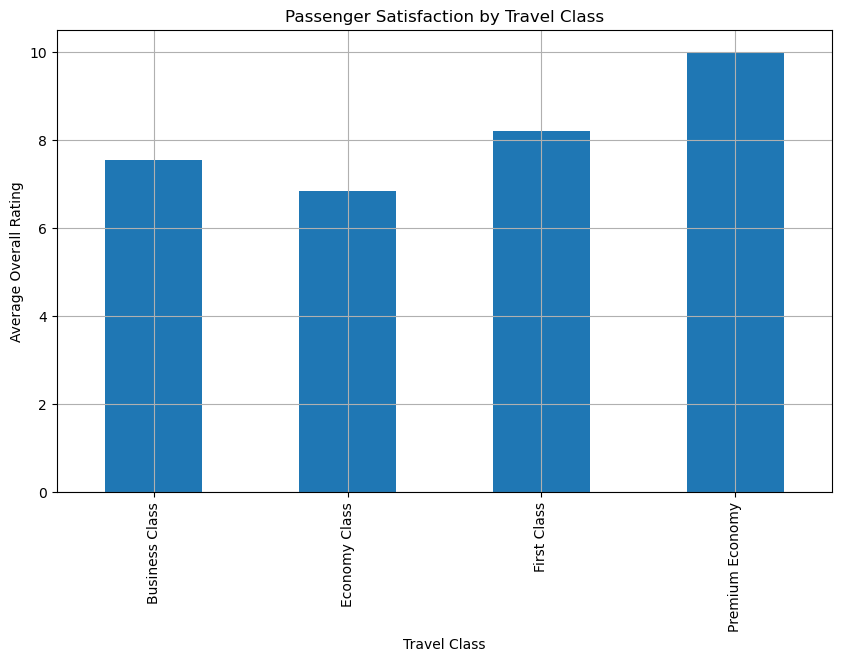

In [103]:
# Calculate the mean overall_rating for each year
class_satisfaction = df.groupby('travel_class')['overall_rating'].mean()

# Plot the yearly satisfaction trend
plt.figure(figsize=(10, 6))
class_satisfaction.plot(kind='bar')
plt.title('Passenger Satisfaction by Travel Class')
plt.xlabel('Travel Class')
plt.ylabel('Average Overall Rating')
plt.grid(True)
plt.show()

In [104]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Perform a one-way ANOVA test
anova_model = ols('overall_rating ~ C(travel_class)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

# Print the ANOVA table
print(anova_table)

                       sum_sq      df          F        PR(>F)
C(travel_class)    295.284572     3.0  10.460127  8.020419e-07
Residual         17022.413167  1809.0        NaN           NaN


p-value: 8.020419e-07. There is a statistically significant difference in overall ratings between the different travel classes.

which specific travel classes differ from each other? In order to do that Tukey's HSD test is performed 

In [106]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=df['overall_rating'], groups=df['travel_class'], alpha=0.05)

# Display the Tukey HSD result
print(tukey_result.summary())

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1          group2     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Business Class   Economy Class  -0.6962    0.0 -1.0825 -0.3099   True
Business Class     First Class   0.6619 0.6546 -0.8102   2.134  False
Business Class Premium Economy   2.4619 0.1495  -0.535  5.4588  False
 Economy Class     First Class   1.3581 0.0788 -0.1014  2.8176  False
 Economy Class Premium Economy   3.1581 0.0338  0.1673  6.1489   True
   First Class Premium Economy      1.8 0.5008  -1.511   5.111  False
---------------------------------------------------------------------


There is a statistically significant difference in ratings between Economy and Business Classes as well as Economy and Premium Economy Classes

In [95]:
# ANOVA test across seasons
anova_season = f_oneway(*[df[df['Season'] == season]['overall_rating'].dropna() for season in season_map.values()])
print(f'ANOVA Test across Seasons: F-statistic={anova_season.statistic}, p-value={anova_season.pvalue}')


ANOVA Test across Seasons: F-statistic=1.3435282420515144, p-value=0.2585405180443214


There is no difference in ratings across the different seasons

##### Route

In [107]:
df.route

0            Washington to Nairobi via Doha
1            Adelaide to Barcelona via Doha
2             Jakarta to Amsterdam via Doha
3                Nairobi to Madrid via Doha
4       San Francisco to Ahmedabad via Doha
                       ...                 
1808                     FRA to SIN via DOH
1809                     MXP to CPT via DOH
1810                     LHR to SIN via DOH
1811                             DOH to HKG
1812                             CPH to DOH
Name: route, Length: 1813, dtype: object

In [108]:
# Split the route column into 'From' and 'To' based on the word 'to'
df[['From', 'To']] = df['route'].str.split(' to ', expand=True)

# Further split the 'To' column to remove any additional text after the destination (like 'via')
df['To'] = df['To'].str.split(' via ').str[0]

In [115]:
df.head()

,index,travel_type,travel_class,route,date,seating_comfort,staff_service,food_quality,entertainment,ground_service,...,recommended,overall_rating,review,year,month,sentiment,month_year,Season,From,To
0,0,Solo Leisure,Economy Class,Washington to Nairobi via Doha,2024-08-01,1.0,2.0,2.0,2.0,1.0,...,no,2.0,A storm in Washington DC Dulles International...,2024.0,8.0,Negative,2024-08,Summer,Washington,Nairobi
1,1,Solo Leisure,Business Class,Adelaide to Barcelona via Doha,2024-06-01,5.0,4.0,1.0,3.0,1.0,...,no,2.0,I recently travelled with Qatar and had a ver...,2024.0,6.0,Negative,2024-06,Summer,Adelaide,Barcelona
2,2,Family Leisure,Economy Class,Jakarta to Amsterdam via Doha,2024-08-01,3.0,4.0,4.0,3.0,1.0,...,no,4.0,"Our flight was 5 hours delayed, so we missed ...",2024.0,8.0,Negative,2024-08,Summer,Jakarta,Amsterdam
3,3,Family Leisure,Business Class,Nairobi to Madrid via Doha,2024-08-01,1.0,4.0,3.0,1.0,3.0,...,no,3.0,"It was my first time flying Qatar, we arrange...",2024.0,8.0,Negative,2024-08,Summer,Nairobi,Madrid
4,4,Couple Leisure,Economy Class,San Francisco to Ahmedabad via Doha,2024-08-01,3.0,3.0,3.0,1.0,2.0,...,no,4.0,My flight was delayed for 8 hours from San Fr...,2024.0,8.0,Negative,2024-08,Summer,San Francisco,Ahmedabad


In [112]:
df.groupby('From')['overall_rating'].mean().tail()

From
 Manila     7.000000
ADL        10.000000
AMM         6.000000
AMS         5.333333
ARN         7.500000
Name: overall_rating, dtype: float64

#### Check for Possible duplicates

In [119]:
df[df.duplicated()]

,index,travel_type,travel_class,route,date,seating_comfort,staff_service,food_quality,entertainment,ground_service,...,recommended,overall_rating,review,year,month,sentiment,month_year,Season,From,To


There were no duplicates in the dataset.

In [113]:
# Save the resulting dataset as a csv for further visualization in Tableau
df.to_csv('qatar_vis.csv',index = False)

#### Data Pre-Processing

Now it is time for data pre-processing before building a machine learning model. Most machine learning algorithms can not work with categorical data. We need to transform the categorical columns in the dataset to numeric data.

In [129]:
df.columns

Index(['index', 'travel_type', 'travel_class', 'route', 'date',
       'seating_comfort', 'staff_service', 'food_quality', 'entertainment',
       'ground_service', 'value_for_money', 'recommended', 'overall_rating',
       'review', 'year', 'month', 'sentiment', 'month_year', 'Season', 'From',
       'To'],
      dtype='object')

Select only features that can be used for modeling.

In [132]:
df_ml= df[['travel_type', 'travel_class', 
       'seating_comfort', 'staff_service', 'food_quality', 'entertainment',
       'ground_service', 'value_for_money', 'recommended', 'overall_rating',
        'year', 'month', 'sentiment', 'Season']]

In [137]:
df_ml.drop('year',axis=1,inplace=True)

In [138]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813 entries, 0 to 1812
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   travel_type      1813 non-null   int64  
 1   travel_class     1813 non-null   int64  
 2   seating_comfort  1813 non-null   float64
 3   staff_service    1813 non-null   float64
 4   food_quality     1813 non-null   float64
 5   entertainment    1813 non-null   float64
 6   ground_service   1813 non-null   float64
 7   value_for_money  1813 non-null   int64  
 8   recommended      1813 non-null   int64  
 9   overall_rating   1813 non-null   float64
 10  month            1813 non-null   float64
 11  sentiment        1813 non-null   int64  
 12  Season           1813 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 184.3 KB


In [134]:
# select the categorical columns
cat_cols = ['travel_type','travel_class','recommended','sentiment','Season']
# Importing the LabelEncoder class from scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Creating an instance of the LabelEncoder
label_encoding = LabelEncoder()

# Looping through each categorical column and applying label encoding to convert them to numeric values
for category in cat_cols:
    df_ml[category] = label_encoding.fit_transform(df_ml[category])


In [139]:
df_ml.head()

,travel_type,travel_class,seating_comfort,staff_service,food_quality,entertainment,ground_service,value_for_money,recommended,overall_rating,month,sentiment,Season
0,3,1,1.0,2.0,2.0,2.0,1.0,1,0,2.0,8.0,0,2
1,3,0,5.0,4.0,1.0,3.0,1.0,1,0,2.0,6.0,0,2
2,2,1,3.0,4.0,4.0,3.0,1.0,2,0,4.0,8.0,0,2
3,2,0,1.0,4.0,3.0,1.0,3.0,1,0,3.0,8.0,0,2
4,1,1,3.0,3.0,3.0,1.0,2.0,2,0,4.0,8.0,0,2


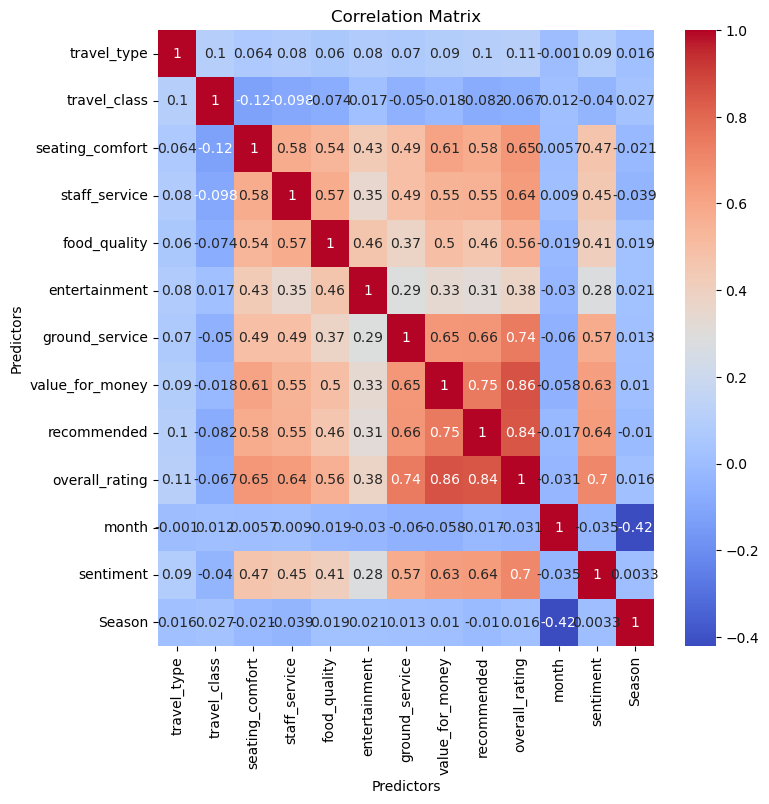

In [140]:
# Create a correlation matrix to analyze predictor correlations
corrMatrix = df_ml.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.xlabel('Predictors')
plt.show()

There were high multi colinearity among some of the predictors. So these columns need to be removed.

In [144]:
df_ml =df_ml.drop('sentiment', axis=1)

In [141]:
df_ml = df_ml.drop(columns = ['overall_rating','value_for_money'] , axis=1)

In [145]:
df_ml.columns

Index(['travel_type', 'travel_class', 'seating_comfort', 'staff_service',
       'food_quality', 'entertainment', 'ground_service', 'recommended',
       'month', 'Season'],
      dtype='object')

### Model Building

The goal of the project is to build a model that predicts whether passengers would recommend Qatar Airlines in the future based on a set of factors.

It is a classification problem and Logistic regression model or tree based models such as random forest, decision tree or XGBOOST models can be used.

No need to standardizse the dataset as all of the features are more or less on the same .

In [151]:
X = df_ml.drop('recommended',axis=1)
y = df_ml['recommended']

In [153]:
y.shape

(1813,)

Let's split the data in to trainning and testing set with 80% and 20% respectively. 

In [172]:
from sklearn.model_selection import train_test_split
# Splitting the data into training and testing sets using the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

In [173]:
X_test.shape

(363, 9)

##### A. Logistic model

In order to use logistic regression models, certain assumptions have to be met with the data we have. These assumptions are:

- The outcome variable should be binary
- Linear relationship between each predictors and logit of the response variable
- No multicollinearity between our predictors
- No extreme outliers
- The observations in the dataset are independent of each other
- Large sample size

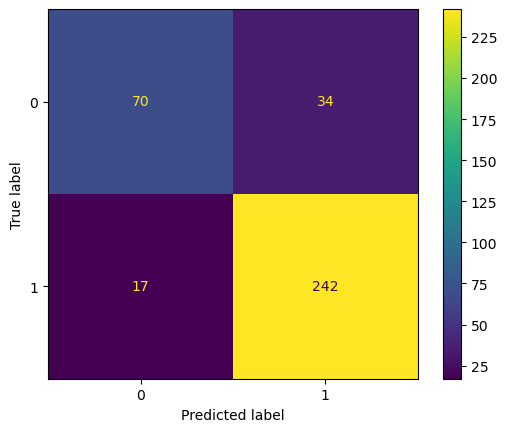

In [191]:
log_model = LogisticRegression(max_iter=500).fit(X_train, y_train)
y_pred_lg=log_model.predict(X_test)
# Displaying the confusion matrix for the logistic regression model
log_cm=confusion_matrix(y_test,y_pred_lg,labels=log_model.classes_)
log_model_disp=ConfusionMatrixDisplay(log_cm,display_labels=log_model.classes_)
log_model_disp.plot(values_format='')
plt.show()

In [194]:
# Evaluate model performance metrics
print("Accuracy_LogR:", "%.4f" % metrics.accuracy_score(y_test, y_pred_lg))  # Accuracy of the logistic regression model
print("Precision:", "%.4f" % metrics.precision_score(y_test, y_pred_lg))      # Precision: TP / (TP + FP)
print("Recall:", "%.4f" % metrics.recall_score(y_test, y_pred))            # Recall: TP / (TP + FN)
print("F1 Score:", "%.4f" % metrics.f1_score(y_test, y_pred_lg))              # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
print("AUC Score:", "%.4f" % metrics.roc_auc_score(y_test, y_pred_lg)) 

Accuracy_LogR: 0.8595
Precision: 0.8768
Recall: 0.9344
F1 Score: 0.9047
AUC Score: 0.8037


##### B. Decision Tree Model

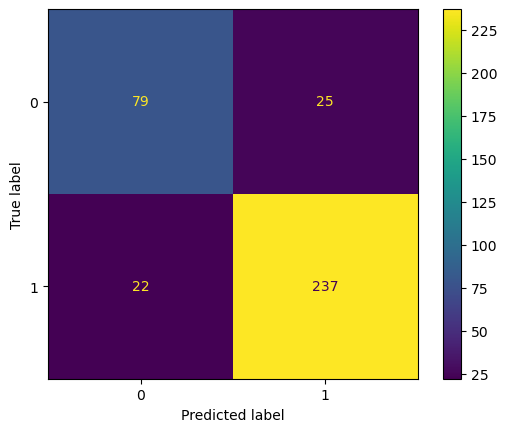

In [174]:
dt=DecisionTreeClassifier(max_depth=6,random_state=42).fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)
dt_cm=confusion_matrix(y_test,y_pred_dt,labels=dt.classes_)
dt_disp=ConfusionMatrixDisplay(dt_cm, display_labels=dt.classes_)
dt_disp.plot(values_format='')
plt.show()

In [175]:
print("Accuracy_decisiontree:", "%.4f" % metrics.accuracy_score(y_test, y_pred_dt))
print("Precision:", "%.4f" % metrics.precision_score(y_test, y_pred_dt))
print("Recall:", "%.4f" % metrics.recall_score(y_test, y_pred_dt))
print("F1 Score:", "%.4f" % metrics.f1_score(y_test, y_pred_dt))
print("AUC Score:", "%.4f" % metrics.roc_auc_score(y_test, y_pred_dt))

Accuracy_decisiontree: 0.8705
Precision: 0.9046
Recall: 0.9151
F1 Score: 0.9098
AUC Score: 0.8373


##### C. Random Forest Classifier

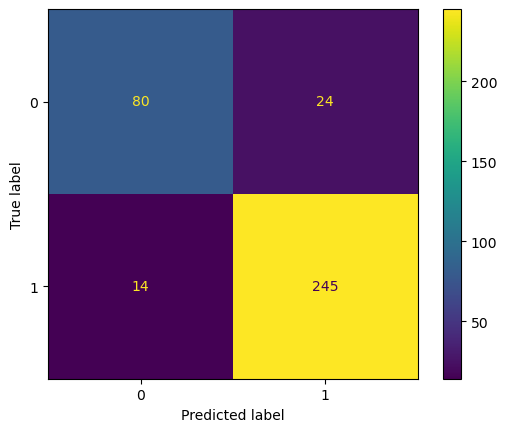

In [176]:
rf = RandomForestClassifier(max_depth=6, n_estimators=500, random_state=1).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_cm = confusion_matrix(y_test,y_pred_rf,labels=rf.classes_)
rf_disp = ConfusionMatrixDisplay(rf_cm,display_labels=rf.classes_)
rf_disp.plot(values_format='')
plt.show()

In [177]:
print("Accuracy_randomforest:", "%.4f" % metrics.accuracy_score(y_test, y_pred_rf))
print("Precision:", "%.4f" % metrics.precision_score(y_test, y_pred_rf))
print("Recall:", "%.4f" % metrics.recall_score(y_test, y_pred_rf))
print("F1 Score:", "%.4f" % metrics.f1_score(y_test, y_pred_rf))
print("AUC Score:", "%.4f" % metrics.roc_auc_score(y_test, y_pred_rf))

Accuracy_randomforest: 0.8953
Precision: 0.9108
Recall: 0.9459
F1 Score: 0.9280
AUC Score: 0.8576


##### D. XGBoost

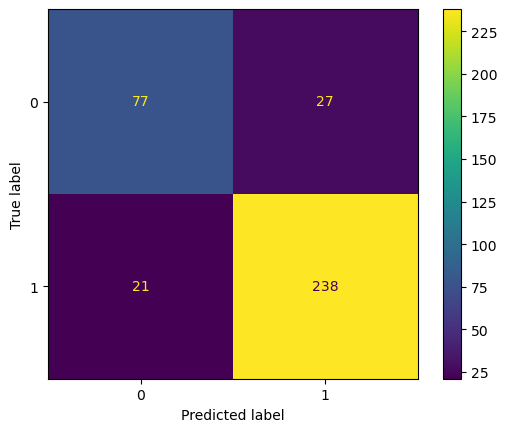

In [178]:
xgb=XGBClassifier(max_depth=6,n_estimators=500,random_state=42).fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)
xgb_cm=confusion_matrix(y_test,y_pred_xgb,labels=xgb.classes_)
xgb_disp=ConfusionMatrixDisplay(xgb_cm,display_labels=xgb.classes_)
xgb_disp.plot(values_format='')
plt.show()

In [179]:
print("Accuracy_Xgboost:", "%.4f" % metrics.accuracy_score(y_test, y_pred_xgb))
print("Precision:", "%.4f" % metrics.precision_score(y_test, y_pred_xgb))
print("Recall:", "%.4f" % metrics.recall_score(y_test, y_pred_xgb))
print("F1 Score:", "%.4f" % metrics.f1_score(y_test, y_pred_xgb))
print("AUC Score:", "%.4f" % metrics.roc_auc_score(y_test, y_pred_xgb))

Accuracy_Xgboost: 0.8678
Precision: 0.8981
Recall: 0.9189
F1 Score: 0.9084
AUC Score: 0.8297


In [180]:
# Evaluate the model on the test set
xgb_score = xgb.score(X_test, y_test)
print(f"Xgboost Model Accuracy on Test Set: {xgb_score:.4f}")

Xgboost Model Accuracy on Test Set: 0.8678


In [189]:
Acc_lm= metrics.accuracy_score(y_test,y_pred_lg)
Acc_dt=metrics.accuracy_score(y_test,y_pred_dt)
Acc_rf=metrics.accuracy_score(y_test,y_pred_rf)
Acc_xgb=metrics.accuracy_score(y_test,y_pred_xgb)
models_df = pd.DataFrame({
    'Model' : ['Logistic Model', 'Decision Tree Classifier', 'Random Forest Classifier','XgBoost'],
    'Score' : [Acc_lm, Acc_dt, Acc_rf, Acc_xgb]
})

models_df.sort_values(by = 'Score', ascending = False)

,Model,Score
2,Random Forest Classifier,0.895317
1,Decision Tree Classifier,0.870523
3,XgBoost,0.867769
0,Logistic Model,0.859504


In [182]:
import plotly.express as px

In [195]:
px.bar(data_frame = models_df, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')

##### Feature Importance

The random forest model performed better and had a higher accuracy and is the champion model for prediction.

Which Features contribute the most to a passenger recommending Qatar Airlines in the futre?

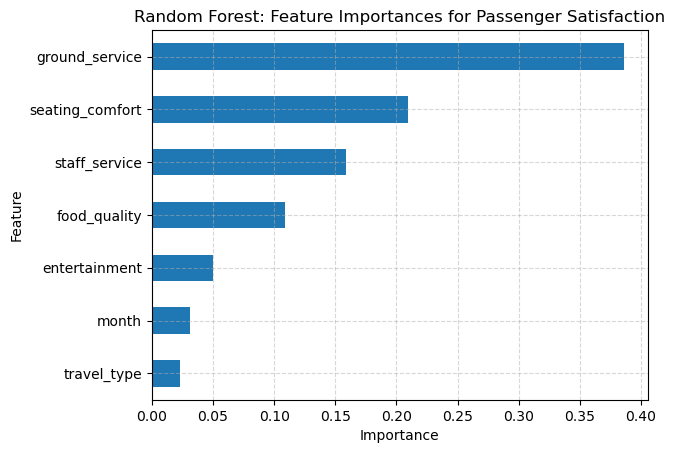

In [198]:
# Get feature importances
feat_impt = rf.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf.feature_importances_, -7)[-7:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]
# create a dataframe and sort it based on importance
y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt}).sort_values("Importance")

# Use a horizontal bar chart for better readability
y_df.plot.barh(x="Feature", y="Importance", title="Random Forest: Feature Importances for Passenger Satisfaction", legend=False)

# It's a good practice to add labels to both axes for clarity.
plt.xlabel("Importance")
plt.ylabel("Feature")

#add line grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Conclusion

Based on the Random Forest classification model, the most important features influencing whether passengers recommend Qatar Airways are:

- Ground Services
- Seating Comfort
- Staff Service
- Food Quality
- Entertainment

These features play a significant role in passengers' likelihood of recommending the airline. The importance of these features indicates that improvements in these areas could significantly enhance overall passenger satisfaction and recommendation rates.

#### Recommendations

- Ground service is the most influential factor, prioritize improvements in areas such as check-in processes, baggage handling, and airport assistance. Ensuring a smooth and pleasant experience before and after the flight can significantly impact passengers' overall satisfaction.
- Seating comfort is crucial for passengers, especially on long-haul flights. Consider upgrading seats, offering more legroom, or providing additional amenities like pillows and blankets.
- Focus on customer service training to ensure that staff are responsive, and efficient in addressing passenger needs.
- Passengers place a high value on the quality of food served during the flight. Improving meal options, catering to dietary preferences, and enhancing the overall dining experience can positively influence passengers’ recommendations.
- In-flight entertainment plays a significant role in passenger satisfaction. Consider updating the content library regularly and offering a variety of entertainment options.